# Nb-Cl Cluster Analysis

This notebook demonstrates the full workflow of the cluster_finder package for analyzing Nb-Cl compounds:

1. Search Materials Project for compounds with Nb and Cl
2. Process compounds to identify clusters
3. Generate lattices with clusters and create supercells
4. Classify dimensionality of compounds
5. Add materials properties and rank clusters
6. Generate visualizations and save final output

## Setup
First, we'll import all required libraries and configure the environment.

In [2]:
# Essential data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Structure handling
from pymatgen.core.structure import Structure

# Utility imports
import ast
import logging

# Import cluster_finder package components
from cluster_finder.utils.helpers import (
    search_transition_metal_compounds,
    get_transition_metals,
    get_mp_properties_batch
)
from cluster_finder.core.clusters import get_compounds_with_clusters
from cluster_finder.analysis.dataframe import (
    cluster_compounds_dataframe,
    postprocessed_clusters_dataframe
)
from cluster_finder.analysis.postprocess import rank_clusters
from cluster_finder.visualization.visualize import visualize_clusters_in_compound
from cluster_finder.utils.async_utils import get_api_key

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("nb_cl_analysis")

# Enable interactive plotting
%matplotlib inline
#plt.style.use('seaborn')

## Configuration

Set up the configuration parameters for the analysis. You'll need to provide your Materials Project API key.

In [ ]:
# Define constants
ELEMENTS = ["Nb", "Cl"]
RAW_OUTPUT_CSV = "Nb_Cl_analysis_results_raw.csv"
SUMMARY_OUTPUT_CSV = "Nb_Cl_analysis_results_summary.csv"

# Get API key
API_KEY = get_api_key("6rcVBNjGRVyfiGPYaLy2xVJNB9X8cN8q")
print(f"Analysis will search for compounds containing: {', '.join(ELEMENTS)}")

Analysis will search for compounds containing: Nb, Cl


## Search Materials Project Database

Search for compounds containing Nb and Cl with specific criteria:

In [6]:
compounds = search_transition_metal_compounds(
    elements=ELEMENTS,
    api_key=API_KEY,
    min_elements=2,
    max_elements=4,
    min_magnetization=0.01,
    max_magnetization=5
)

print(f"Found {len(compounds)} compounds containing {', '.join(ELEMENTS)}")

# Get transition metals for filtering
transition_metals = get_transition_metals()
print(f"Using transition metals: {', '.join(transition_metals)}")

Found 27 compounds containing Nb, Cl
Using transition metals: Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, Hf, Ta, W, Re, Os, Ir, Pt, Au


## Process Compounds to Identify Clusters

Now we'll analyze the compounds to identify clusters and their properties:

In [7]:
compounds_with_clusters = get_compounds_with_clusters(
    compounds,
    transition_metals,
    primary_transition_metal=ELEMENTS[0]
)

# Filter to keep only compounds that have clusters
compounds_with_clusters = [comp for comp in compounds_with_clusters if comp["clusters"]]
print(f"Found {len(compounds_with_clusters)} compounds with clusters")

Found 13 compounds with clusters


## Create and Process Dataframe

Create a dataframe with compound information and process it to add calculated properties:

In [9]:
# Create compounds dataframe
compounds_df = cluster_compounds_dataframe(
    compounds_with_clusters,
    compound_system="-".join(ELEMENTS),
    verbose=True
)

# Post-process the dataframe
processed_df = postprocessed_clusters_dataframe(compounds_df)

# Display basic statistics
print("\nBasic Statistics:")
print(f"Total number of compounds: {len(processed_df)}")
# Flatten the cluster_sizes column and count unique sizes
unique_cluster_sizes = set(size for sizes in processed_df['cluster_sizes'] for size in sizes)
print(f"Number of unique cluster sizes: {len(unique_cluster_sizes)}")
processed_df[['material_id', 'formula', 'num_clusters', 'cluster_sizes']].head()


Basic Statistics:
Total number of compounds: 13
Number of unique cluster sizes: 3


,material_id,formula,num_clusters,cluster_sizes
0,mp-1180763,Nb3(Cl3O4)2,1,[6]
1,mp-561357,TiNb3Cl7O2,2,"[3, 2]"
2,mp-29950,Nb3Cl8,2,"[3, 3]"
3,mp-1211867,KNb3VCl11,4,"[3, 3, 3, 3]"
4,mp-1213417,CsNb3VCl11,4,"[3, 3, 3, 3]"


## Retrieve Additional Materials Properties

Get additional properties from the Materials Project API:

In [10]:
# Extract material IDs
material_ids = processed_df['material_id'].unique().tolist()

# Define properties to retrieve
properties_to_get = [
    "energy_above_hull",
    "formation_energy_per_atom",
    "band_gap",
    "total_magnetization"
]

# Get properties
properties_dict = get_mp_properties_batch(material_ids, properties_to_get, API_KEY)

# Add properties to dataframe
for property_name in properties_to_get:
    property_map = {}
    for material_id, props in properties_dict.items():
        if property_name in props:
            property_map[material_id] = props[property_name]
    
    if property_map:
        processed_df[property_name] = processed_df['material_id'].map(property_map)

# Display properties statistics
processed_df[properties_to_get].describe()

/Users/akhond/Library/CloudStorage/OneDrive-IndianaUniversity/PhD/Research/Cluster Finder Codebase/Git_repo/Cluster_Finder/cluster_finder/utils/async_utils.py:276: RuntimeWarning: coroutine 'async_batch_get_properties' was never awaited
  return results


,energy_above_hull,formation_energy_per_atom,band_gap,total_magnetization
count,13.000000,13.000000,13.000000,13.000000
mean,0.053585,-1.658807,0.240462,1.126189
std,0.133583,0.187849,0.361073,1.285195
min,0.000000,-2.110441,0.000000,0.010255
25%,0.000000,-1.721431,0.000000,0.161042
50%,0.012024,-1.620221,0.038900,0.858525
75%,0.039735,-1.539883,0.260000,1.993224
max,0.492664,-1.454208,0.946300,4.000000


## Rank Clusters

Rank the clusters based on various properties:

In [11]:
ranked_df = rank_clusters(
    data_source=processed_df,
    api_key=API_KEY,
    custom_props=["symmetry", "energy_above_hull"],
    prop_weights={
        "symmetry": 0.0,
        "energy_above_hull": -2.0
    },
    include_default_ranking=True
)

# Display top 10 ranked compounds
display_columns = [
    "material_id", "formula", "num_clusters",
    "predicted_dimentionality", "energy_above_hull", "rank_score"
]
ranked_df[display_columns].head(10)

/Users/akhond/Library/CloudStorage/OneDrive-IndianaUniversity/PhD/Research/Cluster Finder Codebase/Git_repo/Cluster_Finder/cluster_finder/utils/async_utils.py:276: RuntimeWarning: coroutine 'async_batch_get_properties' was never awaited
  return results


,material_id,formula,num_clusters,predicted_dimentionality,energy_above_hull,rank_score
7,mp-29339,Lu(NbCl3)6,1,2D,0.000000,-1.242659
8,mp-568478,Nb6Tl2VCl18,1,2D,0.023889,-1.322691
2,mp-29950,Nb3Cl8,2,2D,0.000000,-1.882800
11,mp-1224709,K(Nb2Cl5)4,4,2D,0.000000,-1.929487
12,mp-686087,Li3(Nb2Cl5)8,8,2D,0.012024,-1.937553
9,mp-570921,CsLu(NbCl3)6,1,2D,0.000000,-2.055665
10,mp-778180,CsTi(NbCl3)6,1,2D,0.017679,-2.125320
1,mp-561357,TiNb3Cl7O2,2,3D,0.000000,-2.485249
4,mp-1213417,CsNb3VCl11,4,2D,0.039735,-2.742188
3,mp-1211867,KNb3VCl11,4,2D,0.052238,-2.779916


## Visualizations

Create various visualizations of the clusters and their properties including:
1. Cluster size distribution
2. Average distance distribution
3. Structure visualization for top compounds
4. Property correlations
5. Dimensionality distribution

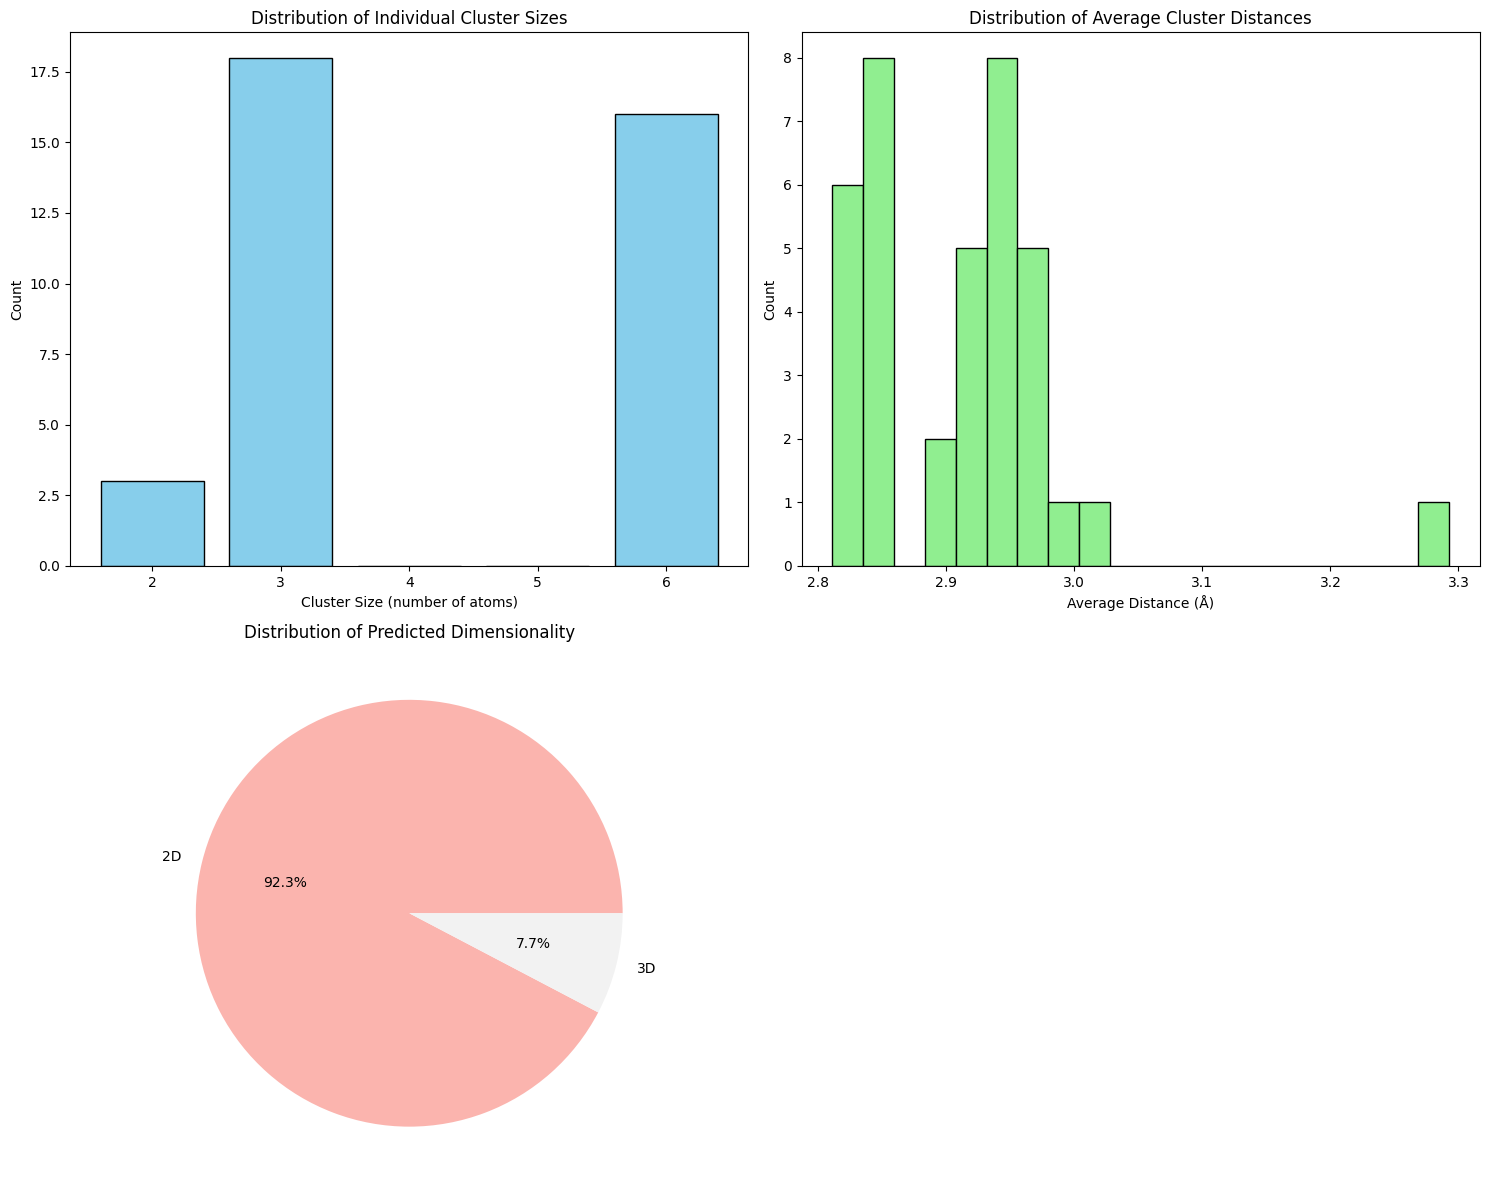

In [22]:
# Create cluster statistics dataframe
cluster_stats_df = pd.DataFrame([
    {
        "material_id": row["material_id"],
        "formula": row["formula"],
        "num_clusters": row["num_clusters"],
        "cluster_sizes": ast.literal_eval(row["cluster_sizes"]) if isinstance(row["cluster_sizes"], str) else row["cluster_sizes"],
        "average_distance": row["average_distance"]
    }
    for _, row in ranked_df.iterrows()
])

# Set up the visualization grid
plt.figure(figsize=(15, 12))

# 1. Cluster size distribution
plt.subplot(221)
all_cluster_sizes = []
for sizes in cluster_stats_df["cluster_sizes"]:
    # Handle potential string representation of list
    if isinstance(sizes, str):
        sizes = ast.literal_eval(sizes)
    all_cluster_sizes.extend(sizes)

if all_cluster_sizes:
    # Use numpy to compute histogram then plot as bar chart
    bins = range(min(all_cluster_sizes), max(all_cluster_sizes)+2)
    hist, bin_edges = np.histogram(all_cluster_sizes, bins=bins)
    
    # Plot as bar chart instead of histogram
    plt.bar(bin_edges[:-1], hist, width=0.8, color='skyblue', edgecolor='black')
    plt.xlabel("Cluster Size (number of atoms)")
    plt.ylabel("Count")
    plt.title("Distribution of Individual Cluster Sizes")
    plt.xticks(bin_edges[:-1])

# 2. Average distance distribution
plt.subplot(222)

# Flatten average_distance lists into a single list of values
all_avg_distances = []
for distances in cluster_stats_df["average_distance"]:
    # Handle potential string representation of list
    if isinstance(distances, str):
        distances = ast.literal_eval(distances)
    all_avg_distances.extend(distances)

plt.hist(all_avg_distances, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Average Distance (Å)")
plt.ylabel("Count")
plt.title("Distribution of Average Cluster Distances")


# 4. Dimensionality distribution
plt.subplot(223)
dim_counts = ranked_df['predicted_dimentionality'].value_counts()
# Create color palette with enough colors for all unique dimensionality values
colors = plt.cm.Pastel1(np.linspace(0, 1, len(dim_counts)))
plt.pie(dim_counts, labels=dim_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Predicted Dimensionality')

plt.tight_layout()
plt.show()

<Figure size 1500x500 with 0 Axes>

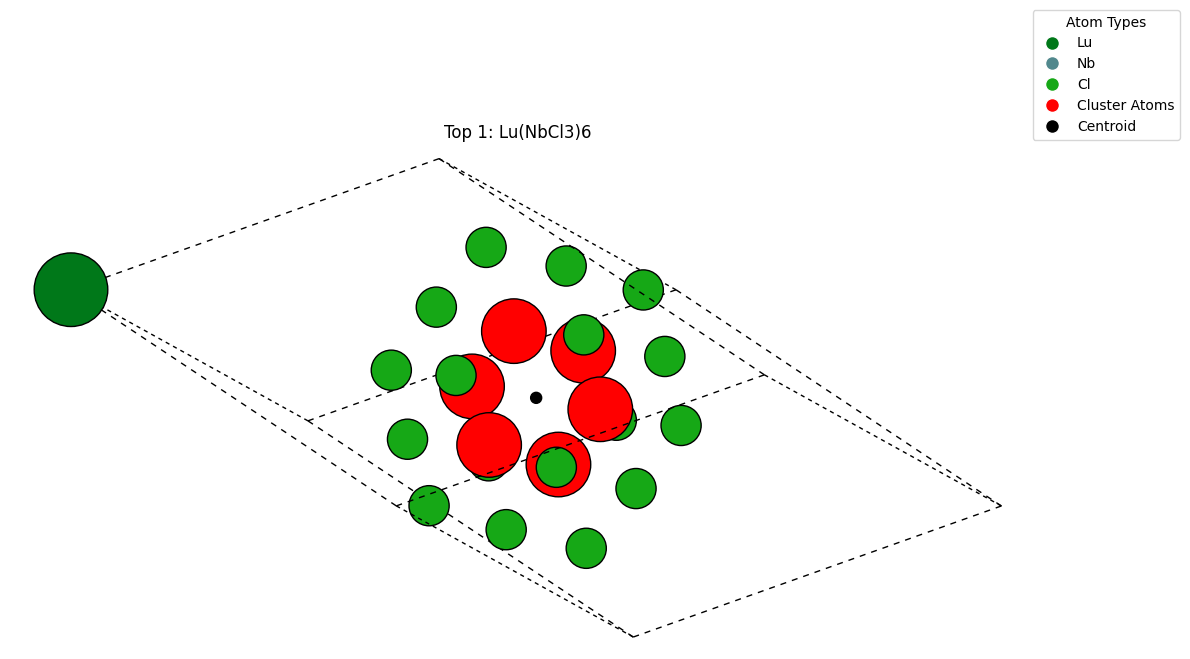

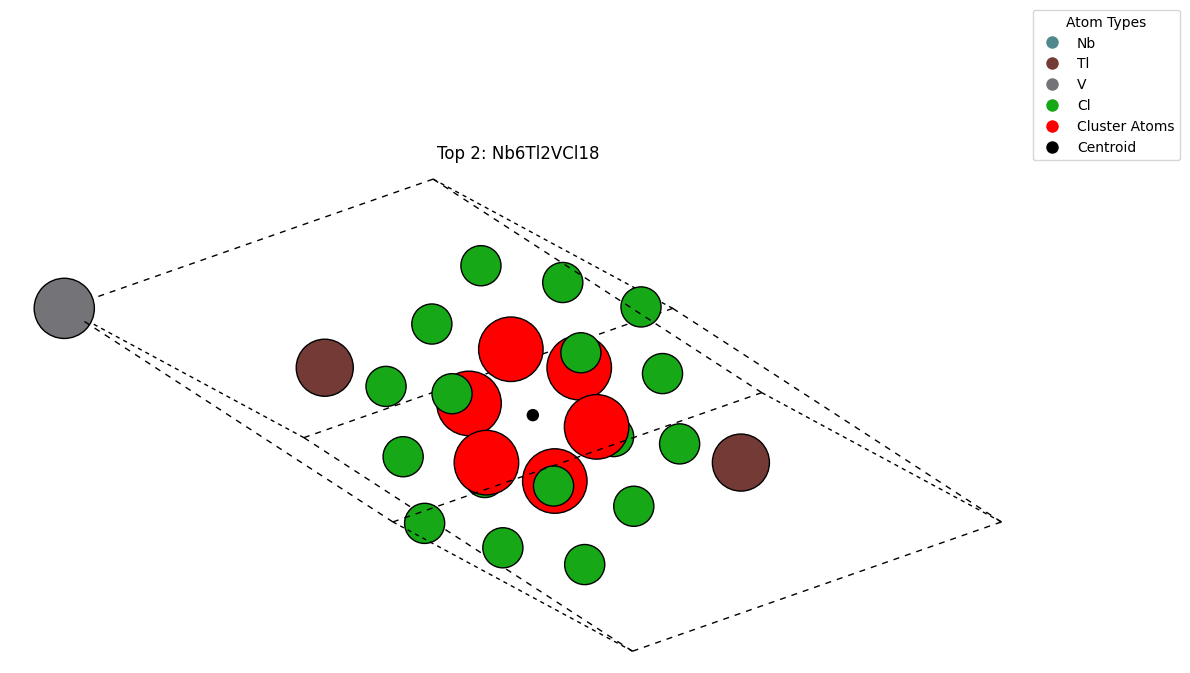

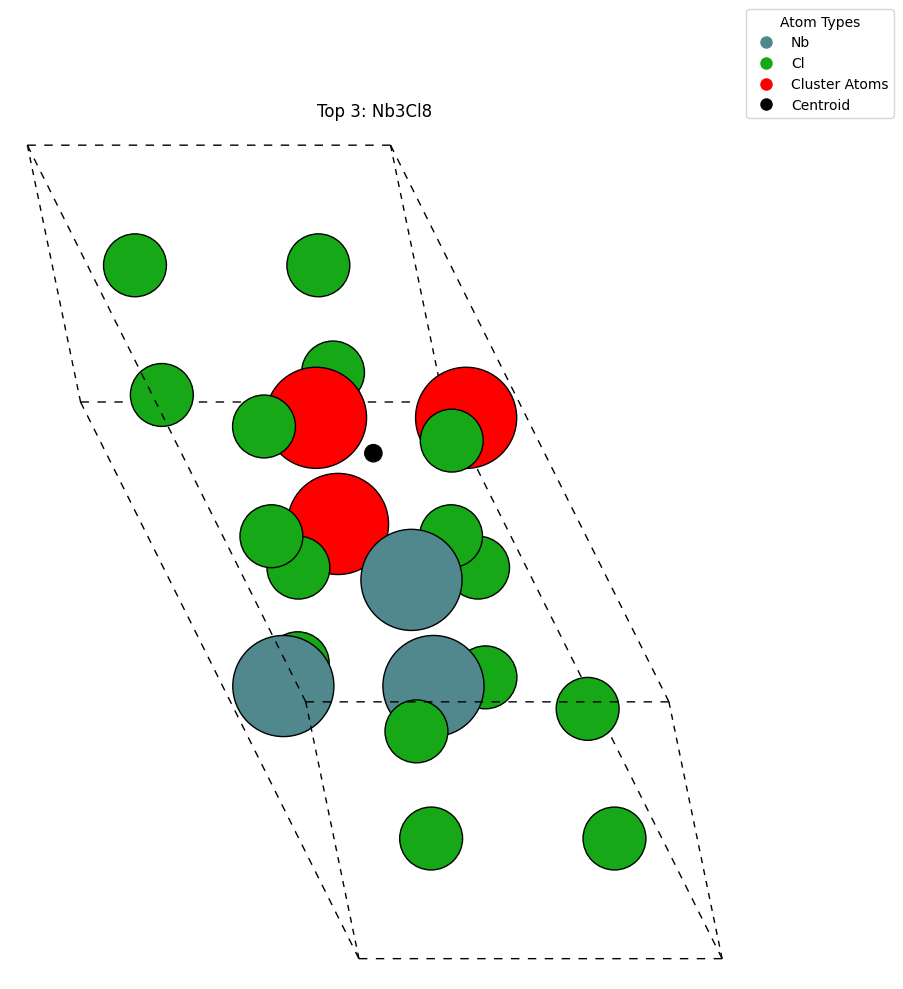

In [26]:
# Additional visualization for top compounds structure
top_compounds = ranked_df.head(3)
fig = plt.figure(figsize=(15, 5))
for idx, (_, compound) in enumerate(top_compounds.iterrows()):
    
    # Get the material ID
    material_id = compound['material_id']
    
    # Find the corresponding compound in compounds_with_clusters
    structure = None
    clusters = None
    for comp in compounds_with_clusters:
        if str(comp['material_id']) == str(material_id):
            structure = comp['structure']
            clusters = comp['clusters']
            break
    
    if structure is None or clusters is None:
        print(f"Could not find structure or clusters for {material_id}")
        continue
    
    visualize_clusters_in_compound(structure, clusters)
    plt.title(f"Top {idx + 1}: {compound['formula']}")
    plt.tight_layout()
    plt.show()

## Export Results

Save the analysis results to CSV files and generate a summary PDF report:

In [ ]:
# Create summary dataframe without large objects
summary_df = ranked_df.drop([
    'magnetization', 'conventional_cluster_lattice', 'cluster_sites',
    'point_groups_dict', 'max_point_group_order', 'highest_point_group',
    'space_group_order', 'structure'
], axis=1, errors='ignore')

# Save processed data
summary_df.to_csv(SUMMARY_OUTPUT_CSV, index=False)
print(f"Saved summary results to {SUMMARY_OUTPUT_CSV}")

# Save detailed results
#ranked_df.to_csv(RAW_OUTPUT_CSV, index=False)
#print(f"Saved detailed results to {RAW_OUTPUT_CSV}")

# Save cluster statistics
#cluster_stats_df.to_csv('cluster_statistics.csv', index=False)
#print("Saved cluster statistics to cluster_statistics.csv")


Saved summary results to Nb_Cl_analysis_results_summary.csv
Generated PDF report: Nb_Cl_analysis_results.pdf
